# 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import gc
import timeit

#gc.collect()
#plt.style.use('ggplot')
#plt.style.use('fivethirtyeight')
#plt.style.use('default')

import seaborn as sns

from scipy.special import kl_div, rel_entr
from scipy.stats import entropy


%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import crossdev_dim as crd
import divariance as dvr

In [2]:

def generate_distributions(mean1, mean2, var1, var2, corr, size=1000):
    """
    Generate two distributions with specified means, variances, and covariance.

    Parameters:
        mean1 (float): Mean of the first distribution.
        mean2 (float): Mean of the second distribution.
        var1 (float): Variance of the first distribution.
        var2 (float): Variance of the second distribution.
        #cov (float): Covariance between the two distributions.
        corr (float): correlation between the two distributions
        size (int): Number of samples to generate.

    Returns:
        x (np.ndarray): Samples from the first distribution.
        y (np.ndarray): Samples from the second distribution.
    """
    # calculate covar
    cov = corr*np.sqrt(var1)*np.sqrt(var2)
    
    # Create the covariance matrix
    cov_matrix = np.array([[var1, cov],
                           [cov, var2]])
    # Mean vector
    mean_vector = np.array([mean1, mean2])
    # Generate samples
    samples = np.random.multivariate_normal(mean_vector, cov_matrix, size)
    x, y = samples[:, 0], samples[:, 1]
    return x, y

# Example usage:
x, y = generate_distributions(mean1=0, mean2=0, var1=1, var2=2, corr=1, size=1000)


In [35]:
x, y = generate_distributions(mean1=0, mean2=0, var1=1, var2=3, corr=1, size=1000)

print(crd.cross_variance(x,y,'ratio'))
print(1-np.sqrt(dvr.dirrelation(x,y)))
print(1/np.sqrt(dvr.dirrelation(x,y)))

1.0750596560774555
0.07028152837029977
1.0755944197248266


0.0
22.2459357171524
inf


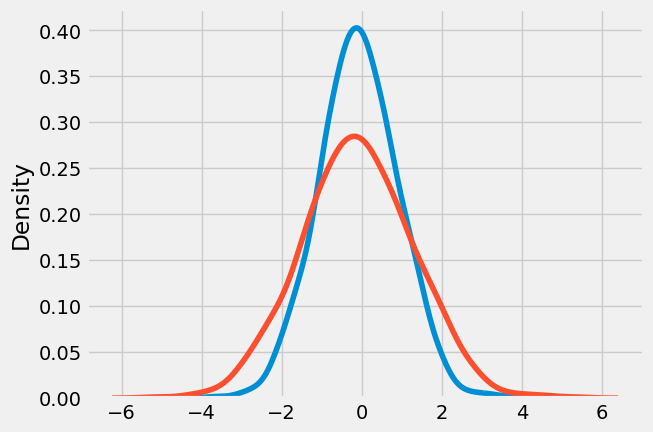

In [3]:

ax,bx = sns.kdeplot(x).get_lines()[0].get_data()
ay,by = sns.kdeplot(y).get_lines()[0].get_data()
print(sum(rel_entr(bx/np.sum(bx),by/np.sum(by))))
print(np.sum(bx))
print(entropy(x,qk=y))

In [4]:
def dist_from_range(arr,drange):
    return ((arr[:]>drange[:-1,np.newaxis])&(arr[:]<=drange[1:,np.newaxis])).sum(axis=1)/len(arr)
#x,y = x_s[0],y_s[0]

def kl_div_from_arrays(x,y):
    min_val = min(np.min(x),np.min(y))-0.01
    max_val = max(np.max(x),np.max(y))
    drange = np.linspace(min_val, max_val,100)
    #np.sum((x>drange[:-1])&(x<=drange[1:]))
    x_pd = dist_from_range(x,drange)
    y_pd = dist_from_range(y,drange)
    return sum(np.nan_to_num(kl_div(x_pd,y_pd),posinf=0))
    #sum(np.nan_to_num(kl_div(y_pd,x_pd),posinf=0))


In [21]:
def KL(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))
#KL(x_s[-1],y_s[-1])

In [5]:
def plot_scatter(x,y, ax=None,return_ax=True,show_ylabel=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)
    ax.set_xlabel('Distr x')
    if show_ylabel:
        ax.set_ylabel('Distr y')
        #ax.set_title('Scatter Plot of Generated Distributions')
    if return_ax:
        return ax
    else:
        plt.show()
    
    #crd.cross_variance(x,y,c_type='ratio'),np.corrcoef(x,y)[0,1]
#_ = plot_scatter(x,y)

In [6]:
def plot_density(x,y, ax=None,return_ax=True):
    if ax is None:
        fig, ax = plt.subplots()
    sns.set_style('whitegrid')
    sns.kdeplot(x, bw_method=0.5,label='x',ax=ax)
    sns.kdeplot(y, bw_method=0.5,label='y',ax=ax)
    #ax.set_title('KDE Plot of Generated Distributions')
    ax.legend();
    if return_ax:
        return ax;
    else:
        plt.show();
#_ = plot_density(x,y)

In [7]:
corr = 1
mean1=0
mean2=0
var1=1
var2=1
cov=var1*var2*corr
size=1000
x, y = generate_distributions(mean1, mean2, var1, var2, corr, size)
#crd.cross_variance(x,y,c_type='ratio'),np.corrcoef(x,y)[0,1]
dvr.divariance(x,y), dvr.dirrelation(x,y)


(np.float64(0.9849516304722001), np.float64(0.9990016454407062))

In [80]:
%%timeit
(dvr.dirrelation(x,y)-1)*2

51.4 μs ± 1.31 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [81]:
%%timeit
kl_div_from_arrays(x,y)

602 μs ± 15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
%%timeit
np.corrcoef(x,y)[0,1]

58.2 μs ± 1.46 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [26]:
%%timeit
(crd.cross_variance(x,y,c_type='ratio')-1)*2

104 μs ± 1.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


599 μs ± 19.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [11]:

distr_default = {'mean1':0, 'mean2':0, 'var1':1, 'var2':1, 'corr':1, 'size':1000}

def generate_metrics(metric, arange, distr_default):
    distr_inputs = distr_default.copy()
    dirr, corr = [],[]
    kl_xy, kl_yx = [],[]
    x_s, y_s = [],[]
    for value in arange:
        distr_inputs[metric]=value
        x, y = generate_distributions(**distr_inputs)
        x_s.append(x)
        y_s.append(y)
        #dirr.append(crd.cross_variance(x,y,c_type='ratio'))
        dirr.append(dvr.dirrelation(x,y))
        corr.append(np.corrcoef(x,y)[0,1])
        kl_xy.append(kl_div_from_arrays(x,y))
        kl_yx.append(kl_div_from_arrays(y,x))
    return dirr, corr, x_s, y_s, kl_xy, kl_yx

#kl_xy, kl_yx = [],[]
#plot_data = {'dirrelation':dirr,'divariance gain x 2':(np.array(dirr)-1)*2,
#            'kl_xy':kl_xy,'kl_yx':kl_yx,'kl_mean':0.5*(np.array(kl_yx)+np.array(kl_xy))}

def plot_metrics_packed(y_data: dict,arange,xlabel='Mean changes: mean2 value',ax=None,return_ax=True):
    if ax is None:
        fig, ax = plt.subplots()
    for k,v in y_data.items():
        ax.plot(arange,v,label=k,alpha=0.7)
    ax.legend()
    if return_ax:
        return ax

def plot_metrics(dirr,corr,kl_xy,kl_yx,arange,xlabel='Mean changes: mean2 value',ax=None,return_ax=True):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(arange,(np.array(dirr)),label='dirrelation')
    ax.plot(arange,(np.array(dirr)-1)*2,label='divariance gain x 2')
    #ax.plot(arange,corr, label='correlation')
    #ax.plot(arange,np.array(corr)/np.array(dirr),label='dicorrelation')
    ax.plot(arange,kl_xy, label='kl_xy')
    ax.plot(arange,kl_yx, label='kl_yx')
    ax.plot(arange,0.5*(np.array(kl_yx)+np.array(kl_xy)), label='kl_mean')
    #ax.set_xlabel(xlabel)
    ax.hlines(1,min(arange),max(arange),color='k',alpha=0.3,linestyles='dotted')
    #plt.gca().invert_xaxis()
    ax.legend()


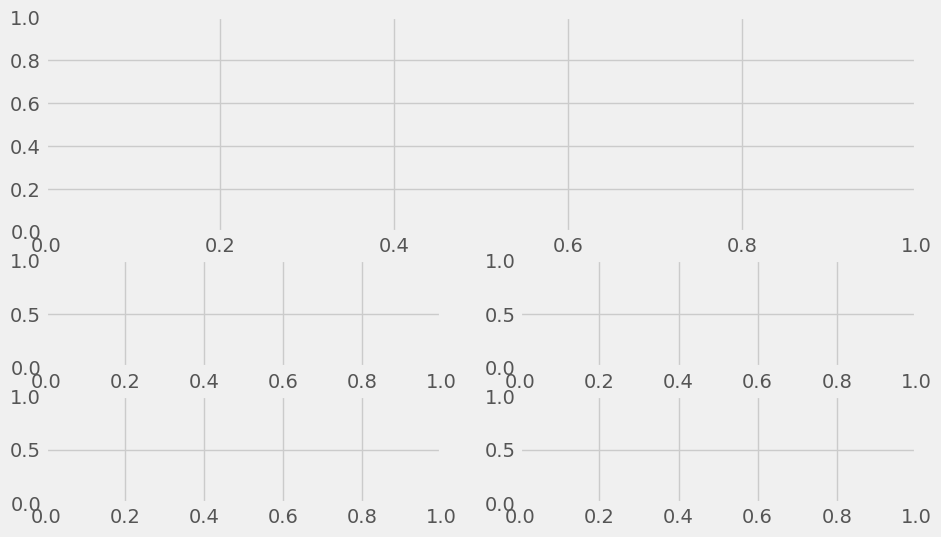

In [70]:
#metric = 'var2'
#arange = np.arange(0.1,2.1,0.1)
default_plot_title = "Effect on KL Divergence and Divariance Gain\nChanging Metric: "
#(1/np.array(dirr)-1)*2 
#(np.sqrt(1/np.array(dirr))-1)
def plot_metric_subplots2(metric,arange,plot_keys,distr_default,scale = 'base',title=f"{default_plot_title}{metric}",savefile=None,support_plots=True):
    dirr, corr, x_s, y_s,kl_xy, kl_yx = generate_metrics(metric, arange, distr_default)
    metrics = {'dirrelation':dirr,'divariance gain x 2': (np.sqrt(1/np.array(dirr))-1)*2,
            'kl_xy':kl_xy,'kl_yx':kl_yx,'kl_mean':0.5*(np.array(kl_yx)+np.array(kl_xy)),
              'correlation':corr,'dicorrelation':np.array(corr)*np.array(dirr)}
    y_data = {k: metrics[k] for k in plot_keys}
    #fig, ax = plt.subplots(figsize=[10,4])
    fig = plt.figure(figsize=[10,8])
    ax = plt.subplot(2,1,1)
    ax.set_ylabel("Corr/dirr")
    if scale == 'log':
        ax.set_xscale('log')
    ax = plot_metrics_packed(y_data,arange,xlabel=f'Metric changes: {metric}',ax=ax)
    ax.set_title(title)
    midpoint = int(len(x_s)/2)
    if ('correlation' in plot_keys) & ('dicorrelation' in plot_keys):
        ax.annotate("",xytext=(arange[0],corr[0]),xy=(arange[0],metrics['dicorrelation'][0]),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        #ax.annotate("",xytext=(arange[0],corr[0]),xy=(arange[0],(corr[0]/dirr[0])),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        ax.annotate("",xytext=(arange[-1],corr[-1]),xy=(arange[-1],metrics['dicorrelation'][-1]),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        #ax.annotate("",xytext=(arange[-1],corr[-1]),xy=(arange[-1],(corr[-1]/dirr[-1])),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
        
        #ax.annotate("",xytext=(arange[midpoint],corr[midpoint]),xy=(arange[midpoint],(corr[midpoint]/dirr[midpoint])),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')

    if support_plots:
        
        #fig, axes = plt.subplots(1,3,figsize=[10,1.5],sharex=True,sharey=True)
        axes=[]
        height_max = 4
        #for x in np.arange(7,13):
        #    ax = plt.subplot(height_max,3,x)
        #    axes.append(ax)
        axes.append(plt.subplot(height_max,3,7))
        axes.append(plt.subplot(height_max,3,8,sharex=axes[0],sharey=axes[0]))
        axes.append(plt.subplot(height_max,3,9,sharex=axes[0],sharey=axes[0]))
        
        _ = plot_density(x_s[0],y_s[0], ax=axes[0],return_ax=True)
        _ = plot_density(x_s[midpoint],y_s[midpoint], ax=axes[1],return_ax=True)
        _ = plot_density(x_s[-1],y_s[-1], ax=axes[2],return_ax=True)
        axes[0].set_title(f"{metric}={arange[0]:.2f}",size='medium')
        axes[1].set_title(f"{metric}={arange[midpoint]:.2f}",size='medium')
        axes[2].set_title(f"{metric}={arange[-1]:.2f}",size='medium')
        #fig.suptitle(f"Density plots at lowest, middle and highest {metric} value")
        #fig, axes = plt.subplots(1,3,figsize=[10,1.5],sharex=True,sharey=True)
    
        axes.append(plt.subplot(height_max,3,10))
        axes.append(plt.subplot(height_max,3,11,sharex=axes[3],sharey=axes[3]))
        axes.append(plt.subplot(height_max,3,12,sharex=axes[3],sharey=axes[3]))
        
        _ = plot_scatter(x_s[0],y_s[0], ax=axes[3],return_ax=True)
        _ = plot_scatter(x_s[midpoint],y_s[midpoint], ax=axes[4],return_ax=True,show_ylabel=False)
        _ = plot_scatter(x_s[-1],y_s[-1], ax=axes[5],return_ax=True,show_ylabel=False)
        plt.tight_layout(h_pad=0.3,w_pad=1)
    if savefile is not None:
        plt.savefig(savefile,bbox_inches='tight')

    plt.show()

def plot_metric_subplots(metric,arange,distr_default,scale = 'base',title=f"{default_plot_title}{metric}"):
    dirr, corr, x_s, y_s,kl_xy, kl_yx = generate_metrics(metric, arange, distr_default)
    fig, ax = plt.subplots(figsize=[10,8])
    ax.set_ylabel("Corr/Dirr")
    if scale == 'log':
        ax.set_xscale('log')
    plot_metrics(dirr,corr,kl_xy, kl_yx,arange,xlabel=f'Metric changes: {metric}',ax=ax)
    
    ax.set_title(title)
    midpoint = int(len(x_s)/2)
    fig, axes = plt.subplots(1,3,figsize=[10,1.5],sharex=True,sharey=True)
    _ = plot_density(x_s[0],y_s[0], ax=axes[0],return_ax=True)
    
    _ = plot_density(x_s[midpoint],y_s[midpoint], ax=axes[1],return_ax=True)
    _ = plot_density(x_s[-1],y_s[-1], ax=axes[2],return_ax=True)
    axes[0].set_title(f"{metric}={arange[0]:.2f}",size='medium')
    axes[1].set_title(f"{metric}={arange[midpoint]:.2f}",size='medium')
    axes[2].set_title(f"{metric}={arange[-1]:.2f}",size='medium')
    
    #fig.suptitle(f"Density plots at lowest, middle and highest {metric} value")
    fig, axes = plt.subplots(1,3,figsize=[10,1],sharex=True,sharey=True)
    
    _ = plot_scatter(x_s[0],y_s[0], ax=axes[0],return_ax=True)
    _ = plot_scatter(x_s[midpoint],y_s[midpoint], ax=axes[1],return_ax=True,show_ylabel=False)
    _ = plot_scatter(x_s[-1],y_s[-1], ax=axes[2],return_ax=True,show_ylabel=False)
    
    plt.show()

Text(5, 0.1, 'Yj')

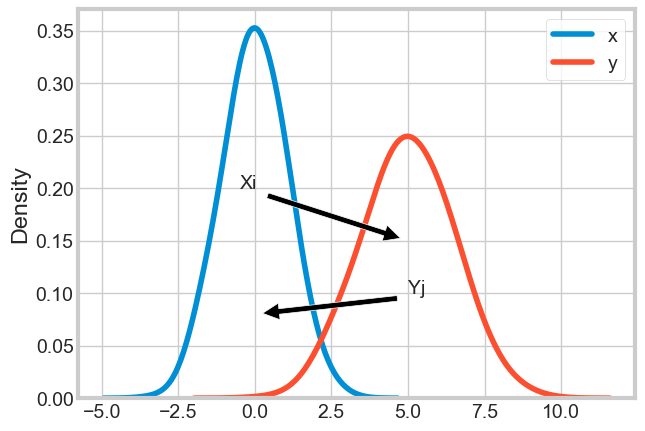

In [96]:
x, y = generate_distributions(mean1=0, mean2=5, var1=1, var2=2, corr=1, size=1000)
ax = plot_density(x,y,return_ax=True)
ax.annotate("Xi",xytext=(-0.5,0.20),xy=(5,0.15),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data')
ax.annotate("Yj",xytext=(5,0.10),xy=(0,0.08),arrowprops=dict(facecolor='black', shrink=0.05)) #,xycoords='data');


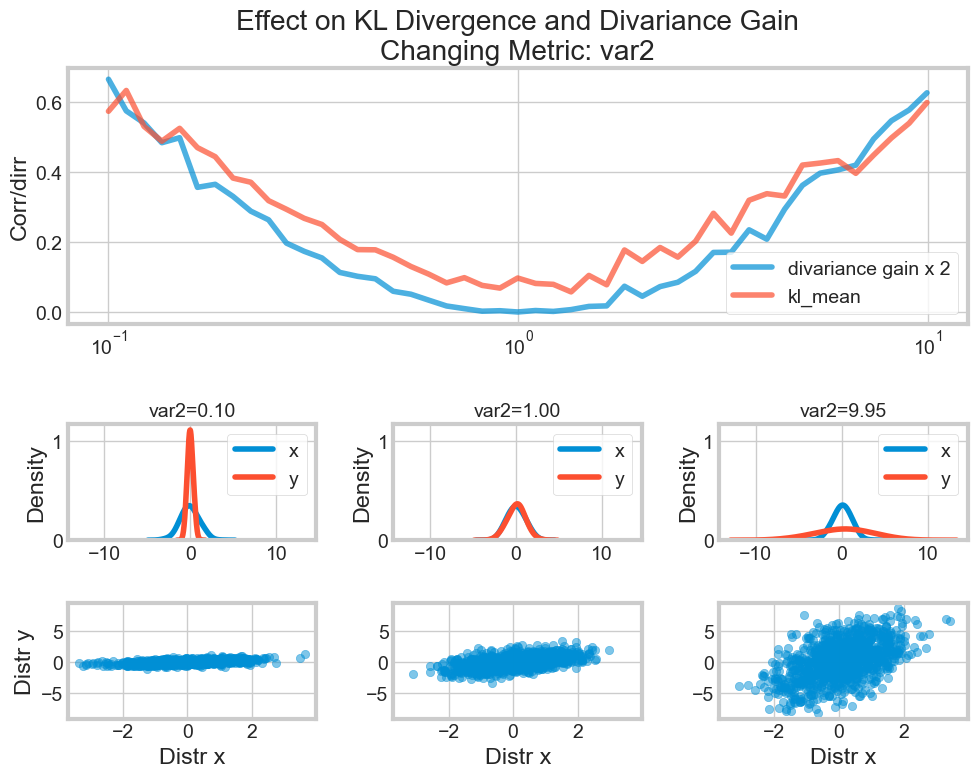

In [64]:
metric = 'var2'
#arange = np.arange(0.1,10.1,0.1)
arange = np.exp(np.arange(np.log(0.1),np.log(10.1),0.1)) #log based range for equal iterations on each side of 1, good for variance, which is symmetrical by ratio
distr_corr=distr_default.copy()
distr_corr['corr']= 0.5

plot_keys = ['divariance gain x 2','kl_mean']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'log',title=f"{default_plot_title}{metric}",savefile='kl_var.png')

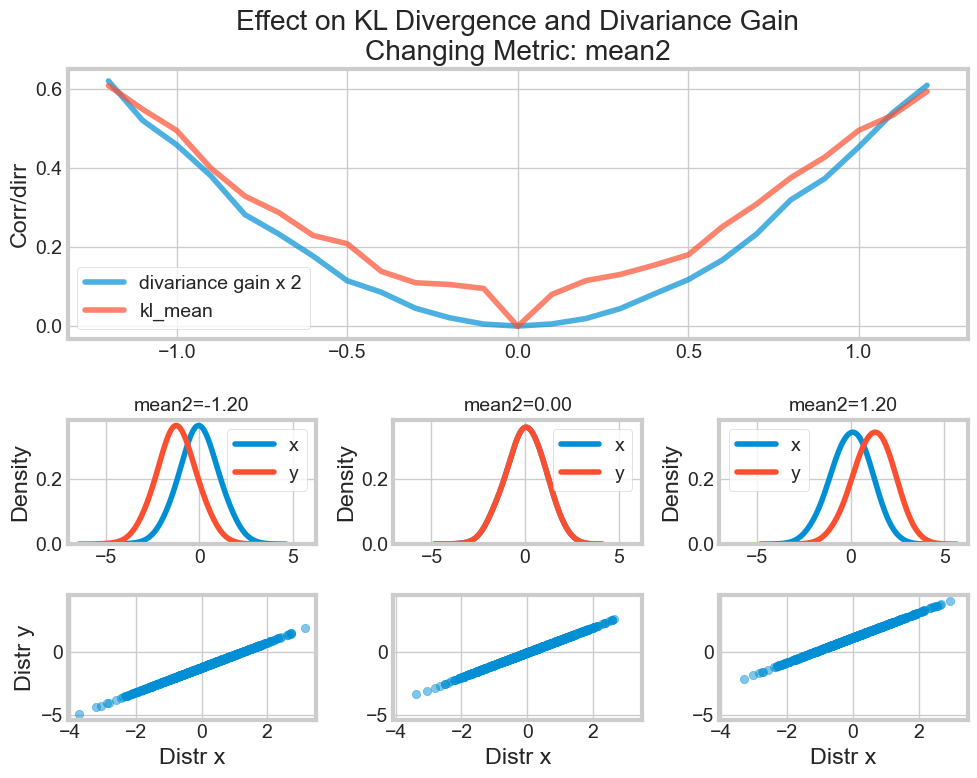

In [63]:
metric = 'mean2'
arange = np.arange(-1.2,1.3,0.1)
distr_corr=distr_default.copy()
distr_corr['corr']= 1

plot_keys = ['divariance gain x 2','kl_mean']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"{default_plot_title}{metric}",savefile='kl_mean.png')

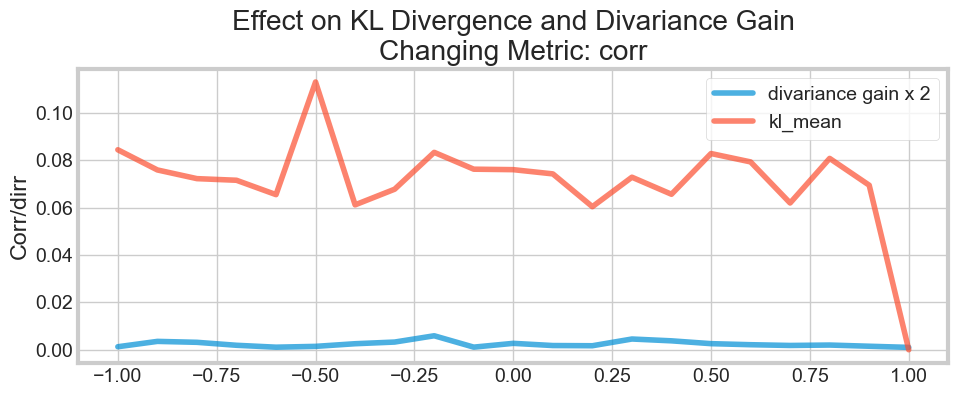

In [65]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
plot_keys = ['divariance gain x 2','kl_mean']
plot_metric_subplots2(metric,arange,plot_keys,distr_default,scale = 'base',title=f"{default_plot_title}{metric}",savefile='kl_corr.png',support_plots=False)

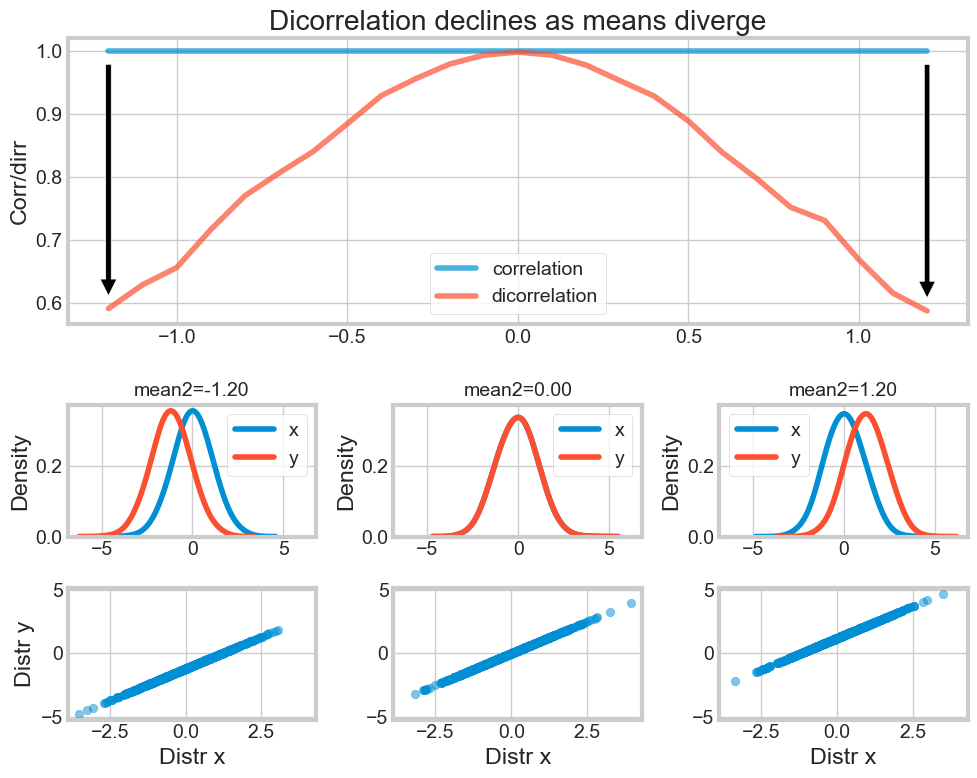

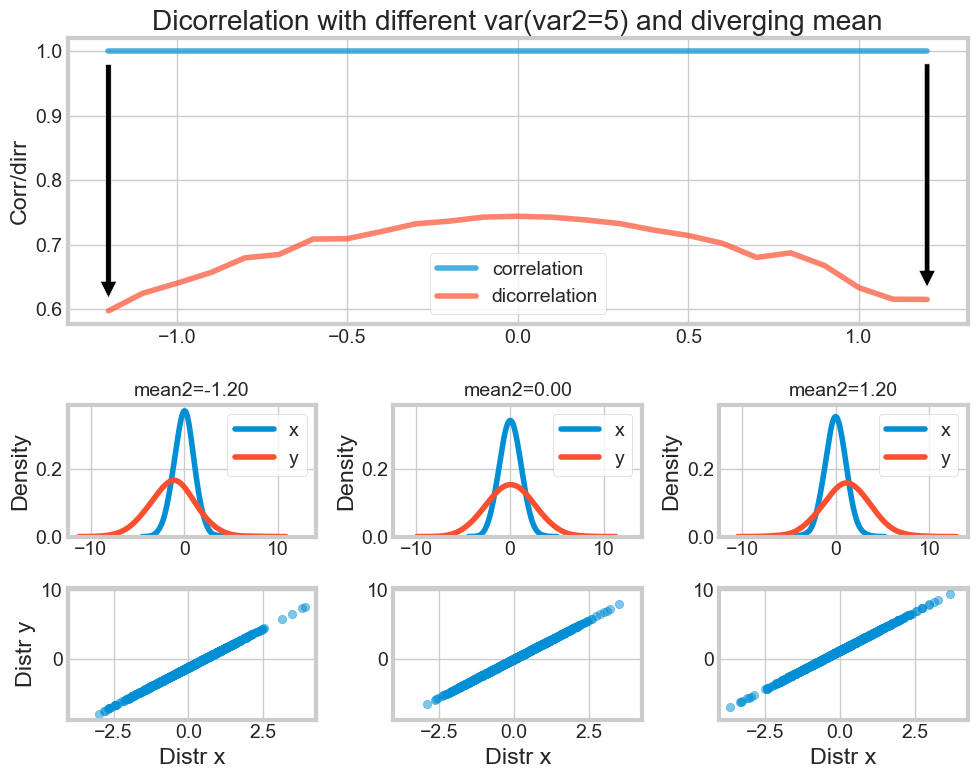

In [78]:
metric = 'mean2'
arange = np.arange(-1.2,1.3,0.1)
distr_corr=distr_default.copy()
#distr_corr['var2']= 5

plot_keys = ['correlation','dicorrelation']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"Dicorrelation declines as means diverge",savefile='corr_mean.png')

distr_corr=distr_default.copy()
distr_corr['var2']= 5
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"Dicorrelation with different var(var2=5) and diverging mean",savefile='corr_mean_var5.png')


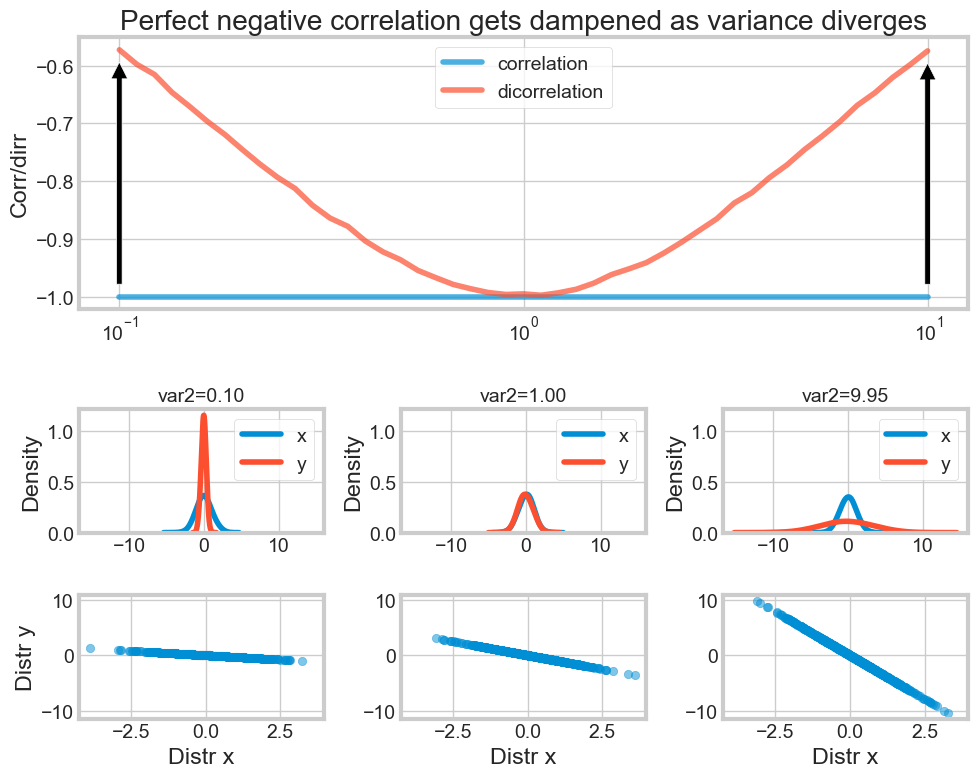

In [73]:
metric = 'var2'
arange = np.exp(np.arange(np.log(0.1),np.log(10.1),0.1)) #log based range for equal iterations on each side of 1, good for variance, which is symmetrical by ratio
distr_corr=distr_default.copy()
#distr_corr['mean2']= 1
distr_corr['corr']= -1

plot_keys = ['correlation','dicorrelation']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'log',title=f"Perfect negative correlation gets dampened as variance diverges",savefile='corr_var.png')

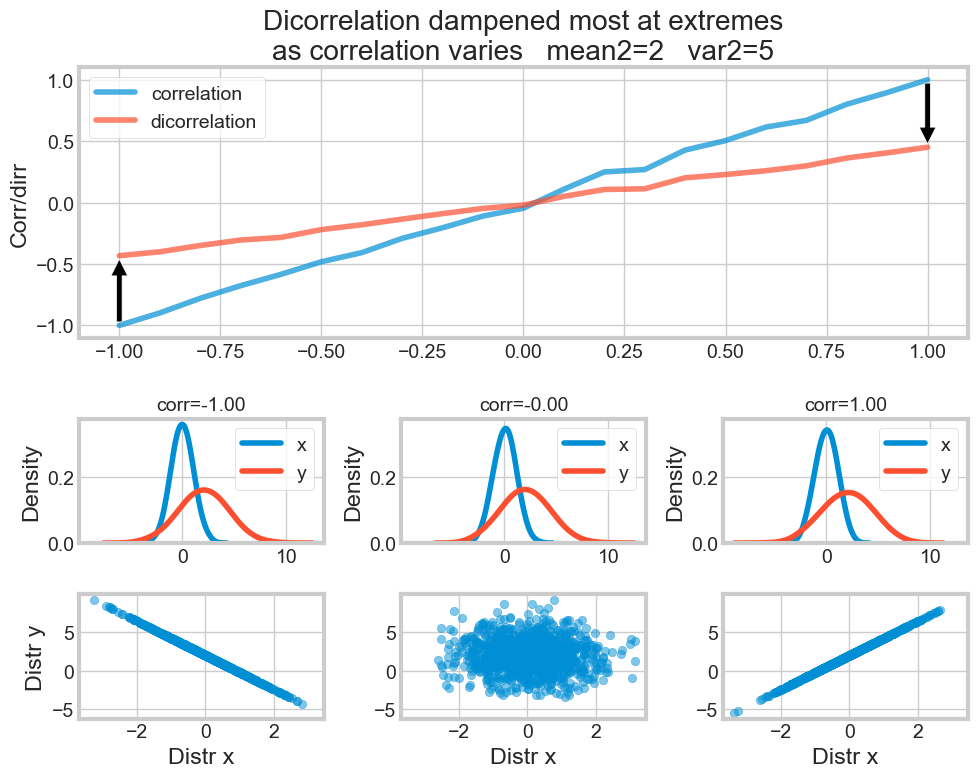

In [75]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
distr_corr=distr_default.copy()
distr_corr['var2']= 5

distr_corr['mean2']= 2

plot_keys = ['correlation','dicorrelation']
plot_metric_subplots2(metric,arange,plot_keys,distr_corr,scale = 'base',title=f"Dicorrelation dampened most at extremes\nas correlation varies   mean2=2   var2=5",savefile='corr_corr.png')


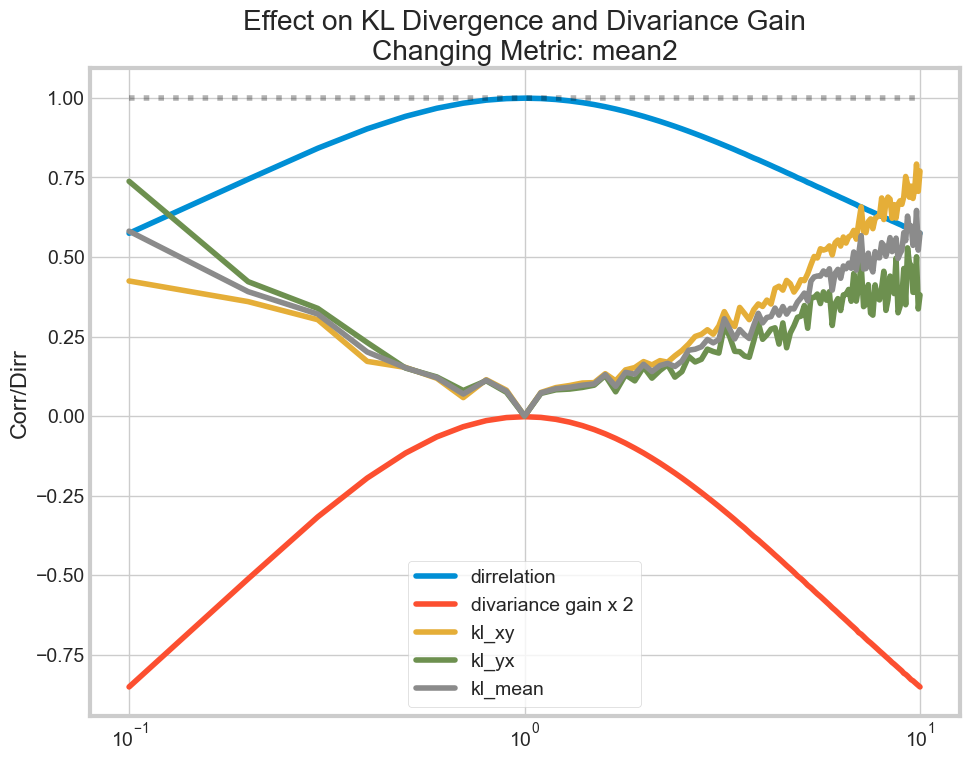

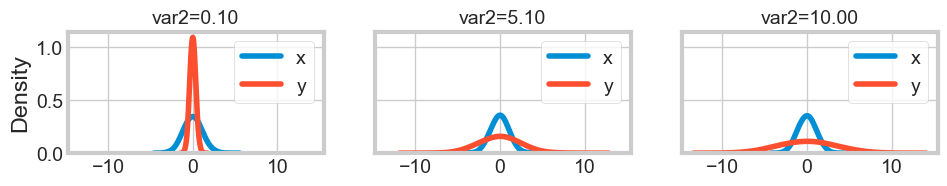

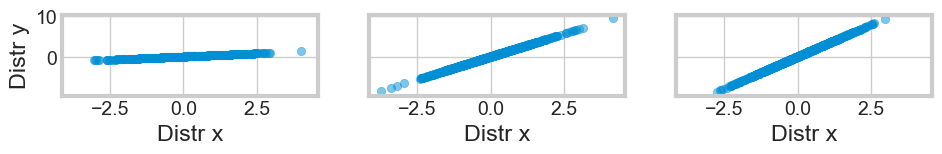

In [76]:
metric = 'var2'
arange = np.arange(0.1,10.1,0.1)
plot_metric_subplots(metric,arange,distr_default,scale = 'log')

## var change analysis
it looks like dirrelation follows relatively closely with KL divergence... especially if you plot it starting at 0 (divariance gain is how I've referred to it)
it might be better to plot on a log scale - its more symmetrical and easier to tell the story.  divariance gain is smoother - less prone to vagaries of samples.  Its also interpretable in terms of variance... the percent increase in variance by swapping labels.  You also can calculate it on arrays directly, vs converting to distributions.

its a smooth closed form calculation, rather than an algorithmic estimation.  Interesting that if you double divariance gain, you essentially get the average of the kl-divergence... kind ofthe shapes are a little different.  

The net of this analysis has less to do with covariance than to do with KL divergence.  thats ok.  It essentially addresses my point... although looking at changing correlation AND var/mean seems interesting... I may or may not address that...

I also could combine correlation and dirrelation to get a join metric (corr/

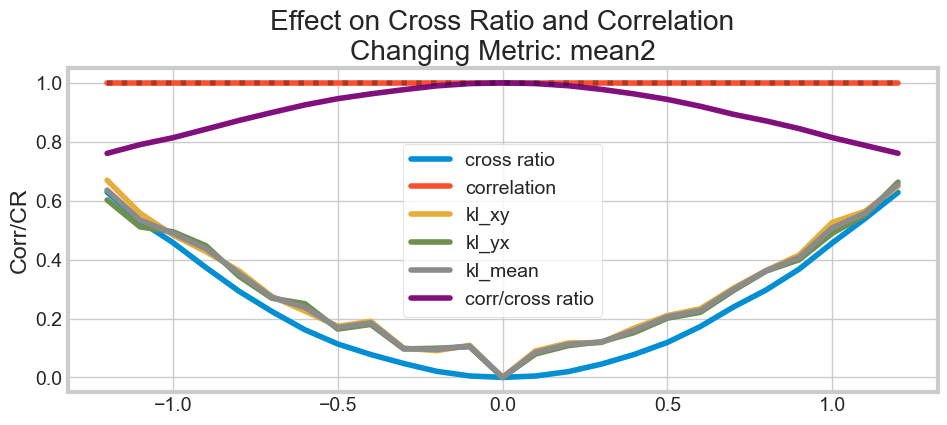

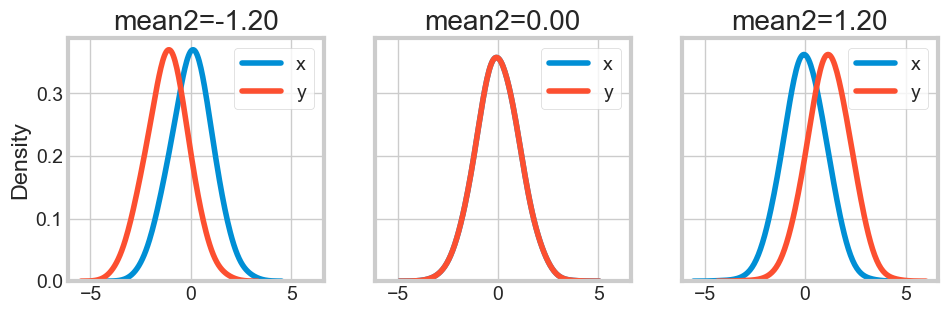

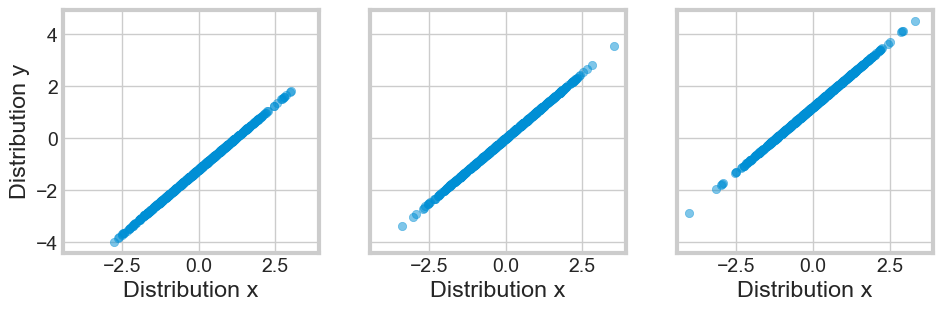

In [369]:
metric = 'mean2'
arange = np.arange(-1.2,1.3,0.1)
plot_metric_subplots(metric,arange,distr_default)

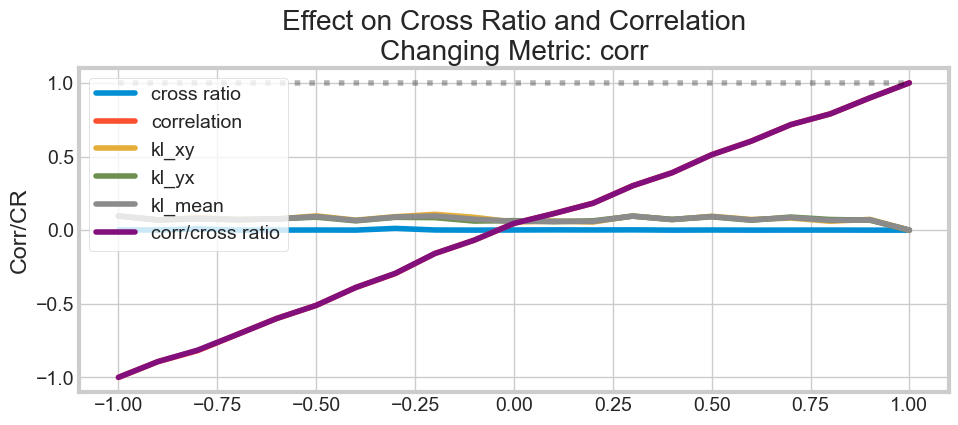

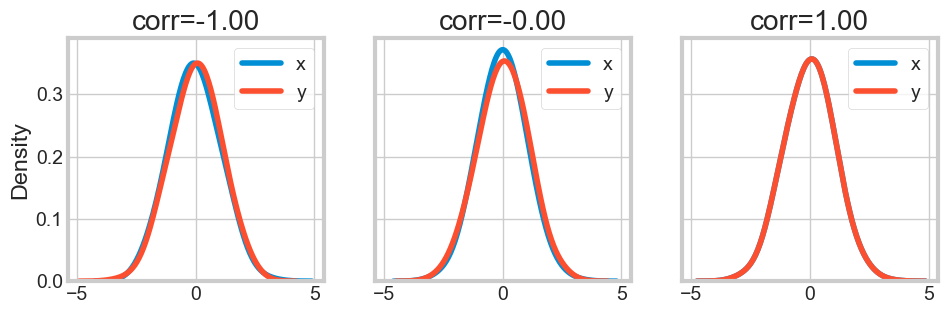

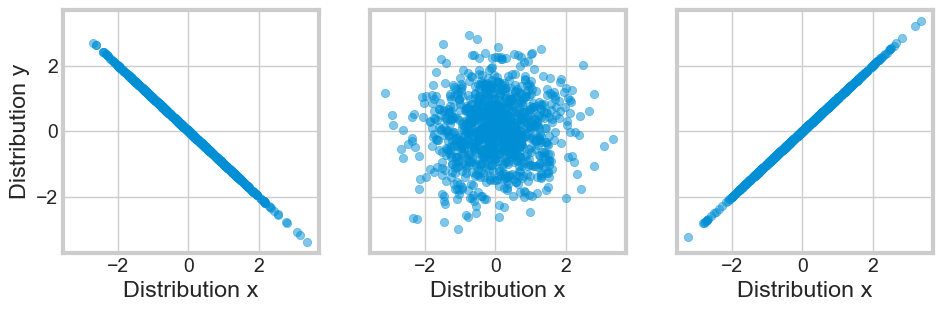

In [370]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
plot_metric_subplots(metric,arange,distr_default)

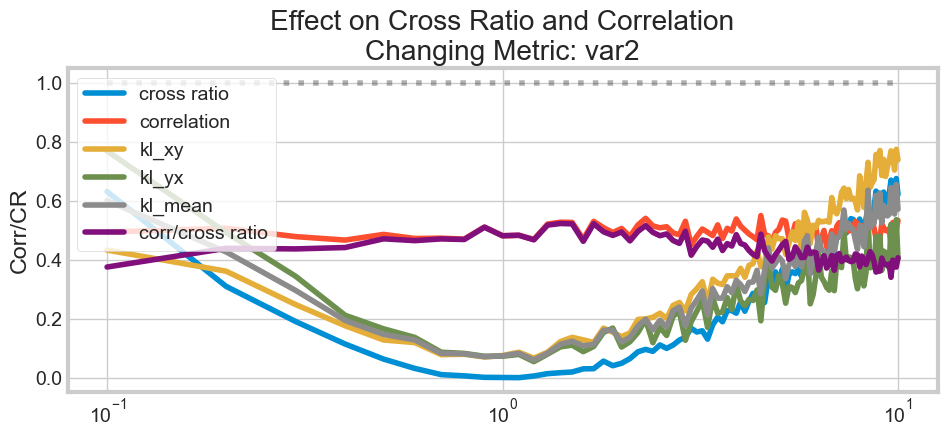

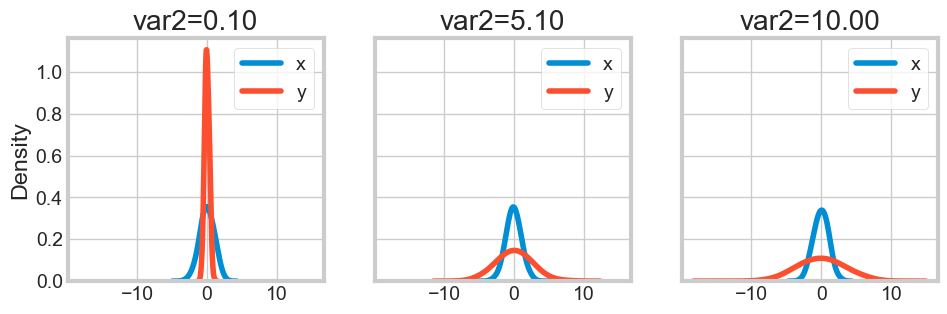

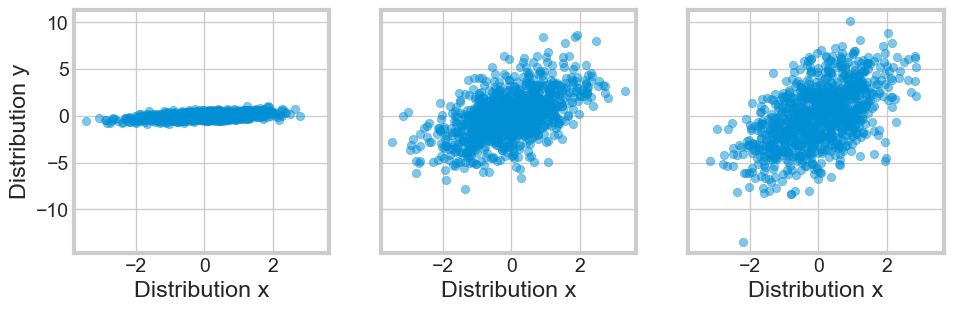

In [371]:
metric = 'var2'
arange = np.arange(0.1,10.1,0.1)
distr_corr=distr_default.copy()
distr_corr['corr']=0.5
plot_metric_subplots(metric,arange,distr_corr,scale = 'log')

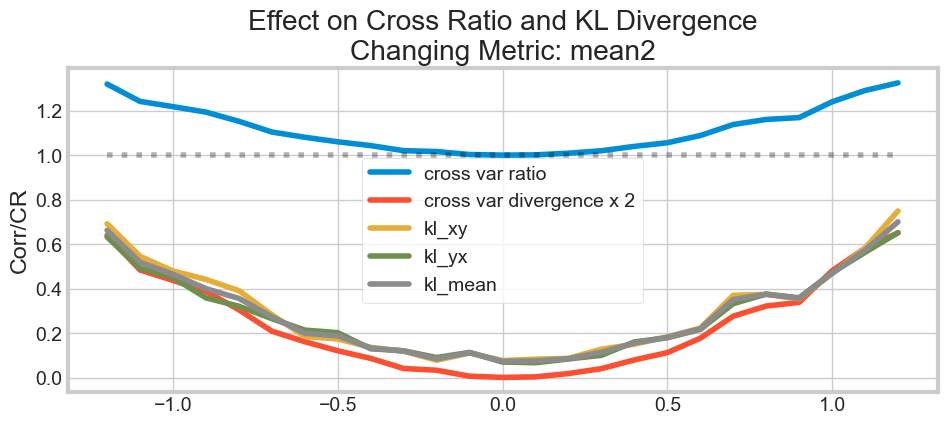

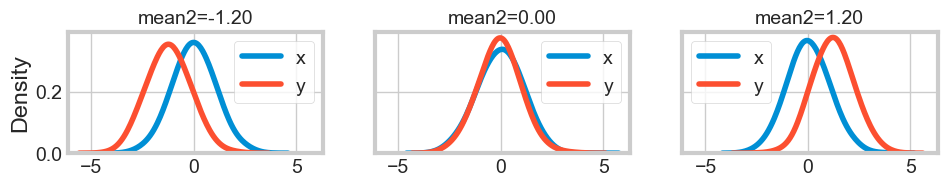

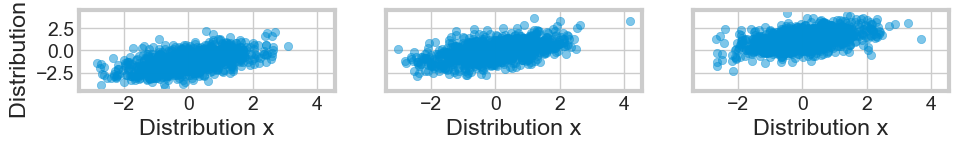

In [413]:
metric = 'mean2'
arange = np.arange(-1.2,1.3,0.1)
distr_corr=distr_default.copy()
distr_corr['corr']=0.5
plot_metric_subplots(metric,arange,distr_corr,scale = 'base',title=f"{defulat_plot_title}{metric}")

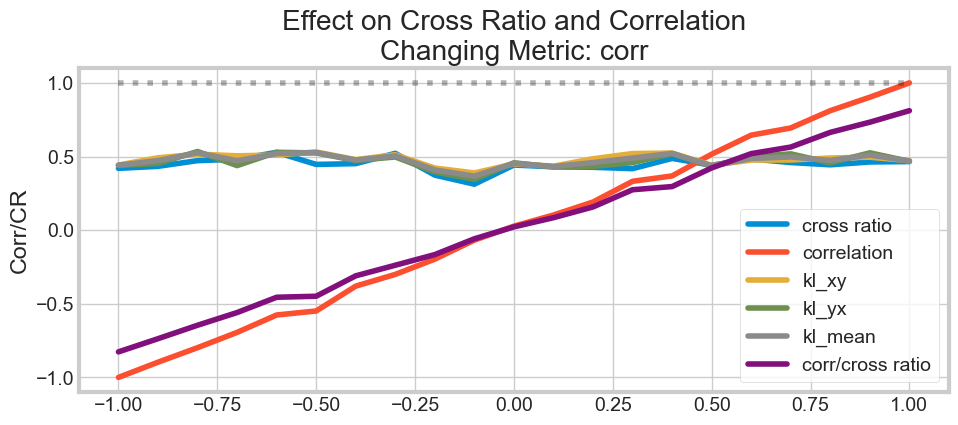

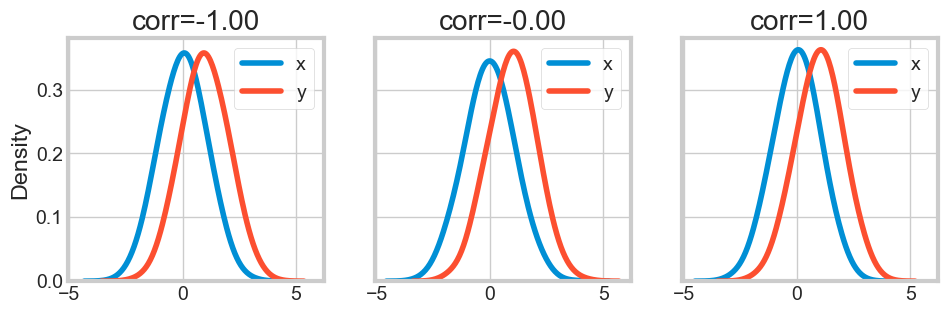

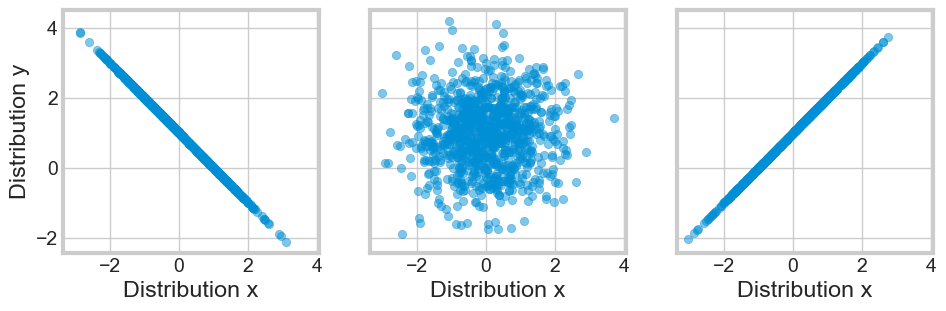

In [374]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
distr_mean=distr_default.copy()
distr_mean['mean2']=1

plot_metric_subplots(metric,arange,distr_mean)

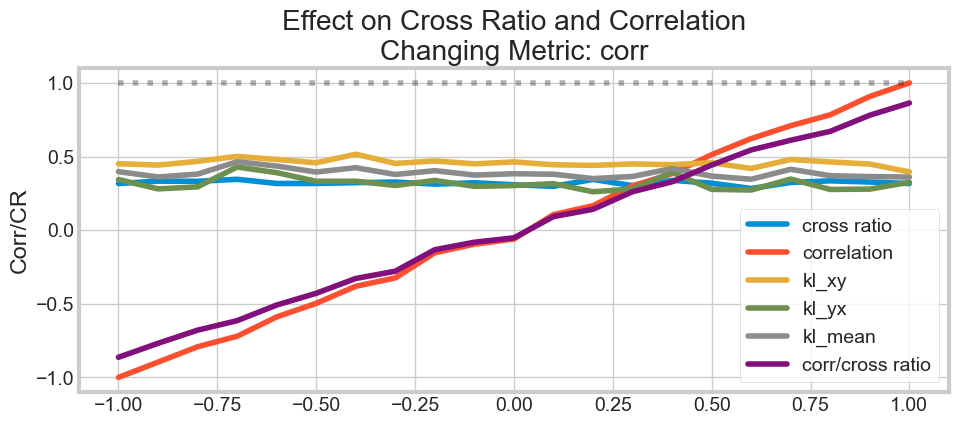

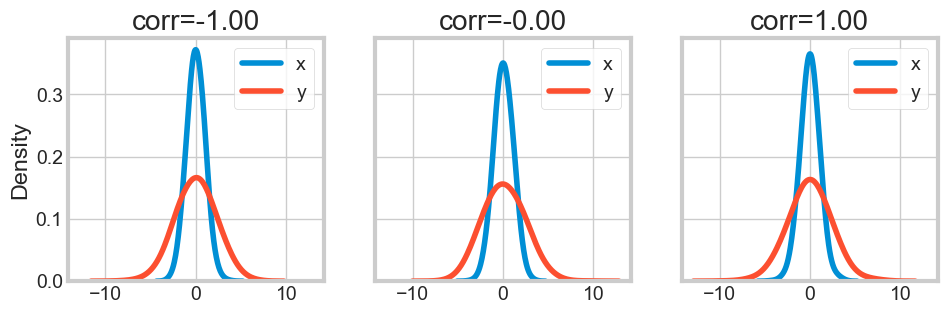

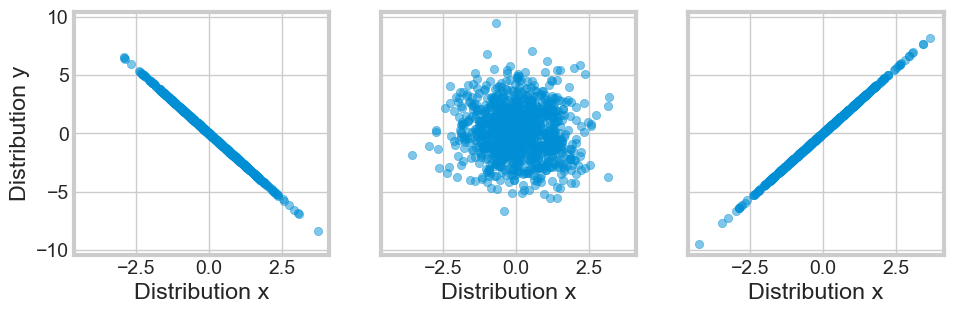

In [376]:
metric = 'corr'
arange = np.arange(-1,1.1,0.1)
distr_var=distr_default.copy()
distr_var['var2']=5

plot_metric_subplots(metric,arange,distr_var)

## Extra code

In [ ]:
fig = plt.figure(figsize=(10,6))
#fig, axes = plt.subplots(3,3,figsize=[10,8],sharex='row',sharey='row')
gs = fig.add_gridspec(3,2,height_ratios=[2,1,1])
ax0=fig.add_subplot(gs[0,:])
ax1=fig.add_subplot(gs[1,0])
ax2=fig.add_subplot(gs[1,1],sharex=ax1)
ax3=fig.add_subplot(gs[2,0])
ax4=fig.add_subplot(gs[2,1])

In [123]:
a, b = 3,1
np.exp(a) - np.exp(b)

np.float64(17.367255094728623)

In [109]:
np.exp(1/a)

np.float64(1.3956124250860895)

In [110]:
np.exp(1/b)

np.float64(2.718281828459045)

In [111]:
np.exp(1/b)*np.exp(1/a)

np.float64(3.7936678946831774)

In [126]:
(np.exp(a/100)-np.exp(b/100))

np.float64(0.02040436686934899)

In [127]:
(np.exp(a) - np.exp(b))/np.exp(10)

np.float64(0.0007884721614678366)

In [131]:
(np.exp(a-100) - np.exp(b-100))*np.exp(100)

np.float64(17.367255094728627)

In [132]:
np.exp(a-100)

np.float64(7.47197233734299e-43)